# Sentiment Analysis Project 🎭

## Overview
This project builds a **Sentiment Analysis** model using **DistilBERT** (a smaller, faster, cheaper version of BERT). The goal is to classify text into three categories:
- **Positive** 🟢
- **Neutral** 🟡
- **Negative** 🔴

We use the [Multiclass Sentiment Analysis Dataset](https://huggingface.co/datasets/Sp1786/multiclass-sentiment-analysis-dataset) from Hugging Face.

### **Steps:**
1.  **Setup & Imports**: Install and load necessary libraries.
2.  **Data Loading**: Load the dataset and inspect it.
3.  **Exploratory Data Analysis (EDA)**: Visualize class distribution and text length.
4.  **Preprocessing**: Clean the text data (remove URLs, mentions, punctuation).
5.  **Tokenization**: Prepare text for the DistilBERT model.
6.  **Model Training**: Train the model using the Hugging Face `Trainer` API (10 Epochs).
7.  **Evaluation**: Evaluate performance using Accuracy, F1-Score, and Confusion Matrix.
8.  **Saving**: Save the model for use in the Streamlit app.

In [ ]:
# Install dependencies if not already installed
%pip install -r requirements.txt


## 1. Setup & Imports 🛠️
We import the necessary libraries for data manipulation, machine learning, and visualization.

In [1]:
import os
# Set environment variables early to prevent tools from looking for TensorFlow or WandB
os.environ["USE_TF"] = "0"
os.environ["WANDB_DISABLED"] = "true"

import re
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 2. Load Dataset 📂
We load the dataset from Hugging Face and filter it to ensure we only have the target labels.

In [2]:
# Load dataset
dataset = load_dataset("Sp1786/multiclass-sentiment-analysis-dataset")
df = dataset["train"].to_pandas()

# Filter for specific classes (Positive, Negative, Neutral)
df = df[['text', 'sentiment']]
df = df[df['sentiment'].isin(['positive', 'negative', 'neutral'])]
df = df.rename(columns={'sentiment': 'label'})

print(f"✅ Data Loaded. Shape: {df.shape}")
df.head()

README.md: 0.00B [00:00, ?B/s]

train_df.csv: 0.00B [00:00, ?B/s]

val_df.csv: 0.00B [00:00, ?B/s]

test_df.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/31232 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5205 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5206 [00:00<?, ? examples/s]

✅ Data Loaded. Shape: (31232, 2)


,text,label
0,"Cooking microwave pizzas, yummy",positive
1,Any plans of allowing sub tasks to show up in ...,neutral
2,"I love the humor, I just reworded it. Like sa...",positive
3,naw idk what ur talkin about,neutral
4,That sucks to hear. I hate days like that,negative


## 3. Exploratory Data Analysis (EDA) 📊
Visualizing the data helps us understand the class balance and the nature of the text.

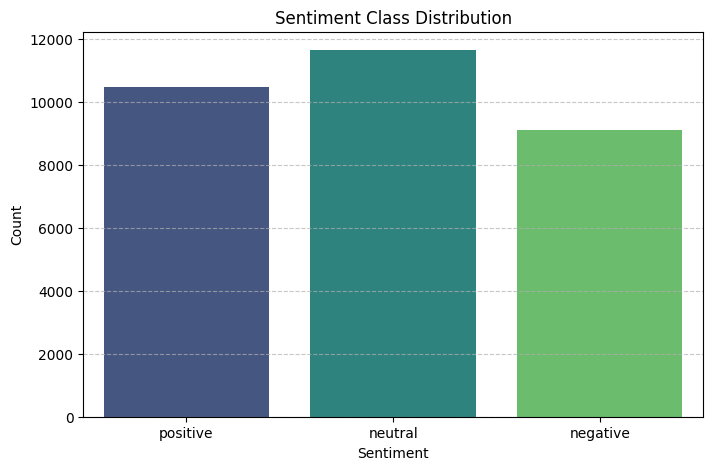

In [3]:
# Class Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df, hue='label', palette='viridis', legend=False)
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

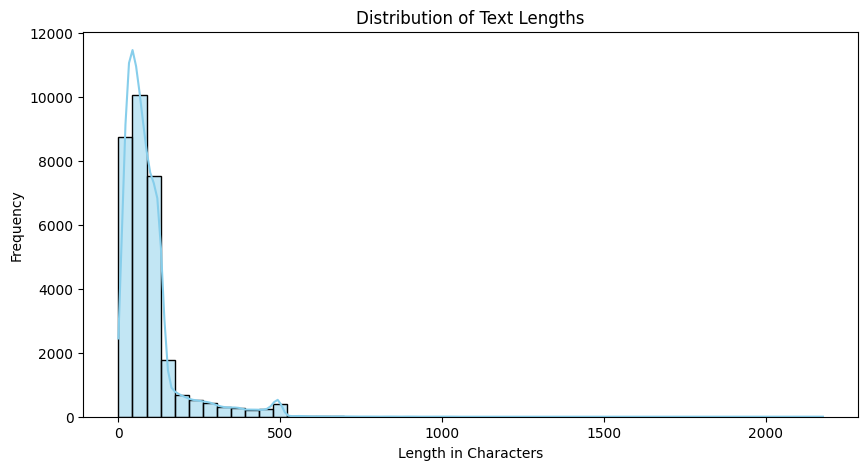

In [4]:
# Text Length Distribution
df['text_length'] = df['text'].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Text Lengths')
plt.xlabel('Length in Characters')
plt.ylabel('Frequency')
plt.show()

### ☁️ Word Clouds
Below are word clouds for each sentiment, showing the most frequent words used.

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128994 (\N{LARGE GREEN CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


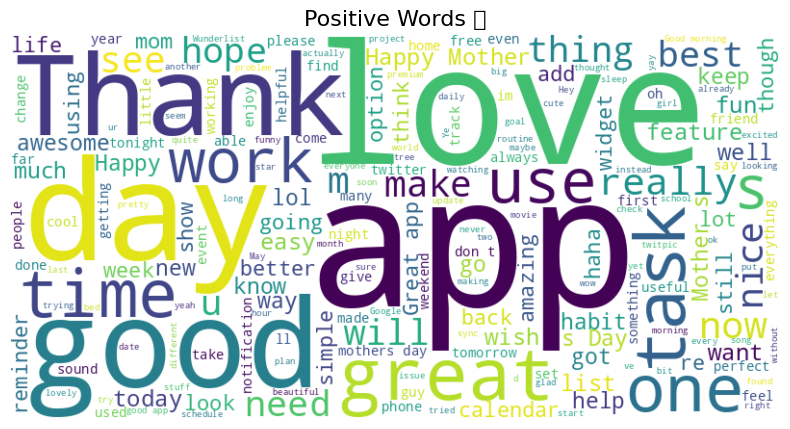

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


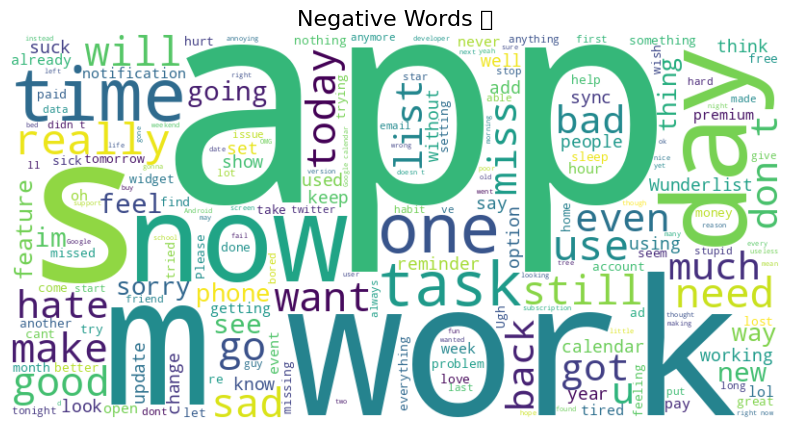

In [5]:
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Generate WordCloud for Positive Sentiment
positive_text = " ".join(df[df['label'] == 'positive']['text'])
plot_wordcloud(positive_text, "Positive Words 🟢")

# Generate WordCloud for Negative Sentiment
negative_text = " ".join(df[df['label'] == 'negative']['text'])
plot_wordcloud(negative_text, "Negative Words 🔴")

## 4. Preprocessing 🧹
We apply text cleaning to remove noise that might affect the model.
- Lowercase text
- Remove URLs and Mentions (@user)
- Remove punctuation and numbers

In [6]:
def clean_text(text):
    if not isinstance(text, str): return ''
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r"@\w+", "", text)            # remove mentions
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) # remove punctuation
    text = re.sub(r"\d+", "", text)             # remove numbers
    text = re.sub(r"\s+", " ", text).strip()    # remove extra whitespace
    return text

# Apply cleaning
df["clean_text"] = df["text"].apply(clean_text)

# Map labels to integers
label_map = {'negative': 0, 'neutral': 1, 'positive': 2}
id2label = {0: 'negative', 1: 'neutral', 2: 'positive'}
label2id = label_map

df['label_id'] = df['label'].map(label_map)

# Check for invalid labels (NaNs)
df.dropna(subset=['label_id'], inplace=True)
df['label_id'] = df['label_id'].astype(int)

print("✅ Preprocessing Complete.")
df[['text', 'clean_text', 'label', 'label_id']].head()

✅ Preprocessing Complete.


,text,clean_text,label,label_id
0,"Cooking microwave pizzas, yummy",cooking microwave pizzas yummy,positive,2
1,Any plans of allowing sub tasks to show up in ...,any plans of allowing sub tasks to show up in ...,neutral,1
2,"I love the humor, I just reworded it. Like sa...",i love the humor i just reworded it like sayin...,positive,2
3,naw idk what ur talkin about,naw idk what ur talkin about,neutral,1
4,That sucks to hear. I hate days like that,that sucks to hear i hate days like that,negative,0


## 5. Tokenization & Splitting ✂️
We split the data into training and validation sets (80-20 split) and tokenize them using DistilBERT's tokenizer.

In [7]:
# Split Data
train_df, eval_df = train_test_split(
    df, 
    test_size=0.2, 
    random_state=seed, 
    stratify=df['label_id']
)

# Convert to Hugging Face Dataset
train_dataset = Dataset.from_pandas(train_df[['clean_text', 'label_id']].rename(columns={'clean_text': 'text', 'label_id': 'label'}), preserve_index=False)
eval_dataset = Dataset.from_pandas(eval_df[['clean_text', 'label_id']].rename(columns={'clean_text': 'text', 'label_id': 'label'}), preserve_index=False)

# Load Tokenizer
MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)

print("✅ Tokenization Complete.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/24985 [00:00<?, ? examples/s]

Map:   0%|          | 0/6247 [00:00<?, ? examples/s]

✅ Tokenization Complete.


## 6. Model Training 🏋️
We initialize **DistilBERT** and the **Trainer**.

**Enhancements:**
- **Increased Epochs**: Trained for **10 epochs** for better convergence.
- **Hyperparameters**: Lower learning rate (2e-5) with Cosine Scheduler for high performance.
- **Early Stopping**: Stop training if validation loss doesn't improve for 3 evaluations.
- **Save Strategy**: Save the model every epoch (load the best one at the end).

In [8]:
# Initialize Model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_map),
    id2label=id2label,
    label2id=label2id
)

# Define Metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted', zero_division=0)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "f1": f1, "precision": precision, "recall": recall}

# Training Arguments
training_args = TrainingArguments(
    output_dir="./results_en",
    fp16=torch.cuda.is_available(),  # Enable Mixed Precision if GPU is available
    num_train_epochs=10,             # Increased to 10 epochs for maximum performance
    learning_rate=2e-5,              # Lower learning rate for stable fine-tuning
    lr_scheduler_type="cosine",      # Cosine annealing for better convergence
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,
    dataloader_num_workers=2,        # Preload data in background
    optim="adamw_torch_fused",       # Faster fused optimizer
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs_en',
    logging_steps=100,
    eval_strategy="epoch",      
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"                 # Disable WandB/Tensorboard to prevent errors
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_eval,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("🚀 Starting Training... (10 Epochs)")
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🚀 Starting Training... (10 Epochs)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.719200,0.654354,0.721146,0.722587,0.726545,0.721146
2,0.598800,0.625595,0.731711,0.729802,0.730093,0.731711
3,0.502400,0.626070,0.733952,0.735051,0.736894,0.733952
4,0.403600,0.671063,0.739235,0.740925,0.745325,0.739235
5,0.304300,0.770430,0.735873,0.735701,0.735824,0.735873
6,0.234100,0.842665,0.731871,0.731668,0.731918,0.731871
7,0.193200,0.923503,0.728670,0.727393,0.726871,0.728670


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

TrainOutput(global_step=2737, training_loss=0.4435978165759978, metrics={'train_runtime': 1219.3272, 'train_samples_per_second': 204.908, 'train_steps_per_second': 3.207, 'total_flos': 5792074713573120.0, 'train_loss': 0.4435978165759978, 'epoch': 7.0})

## 7. Evaluation & Visualization 📈
We evaluate the model on the test set and visualize the results.

In [9]:
# Evaluate
results = trainer.evaluate()
print("📊 Evaluation Results:", results)

# Get Predictions
preds_output = trainer.predict(tokenized_eval)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


📊 Evaluation Results: {'eval_loss': 0.6710625886917114, 'eval_accuracy': 0.7392348327197055, 'eval_f1': 0.7409250536861673, 'eval_precision': 0.7453251407710021, 'eval_recall': 0.7392348327197055, 'eval_runtime': 12.1971, 'eval_samples_per_second': 512.171, 'eval_steps_per_second': 8.035, 'epoch': 7.0}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/usr/local/lib/python3.12/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


### Confusion Matrix & Training History
We plot the confusion matrix to see where the model makes mistakes, and the loss curves to check for overfitting.

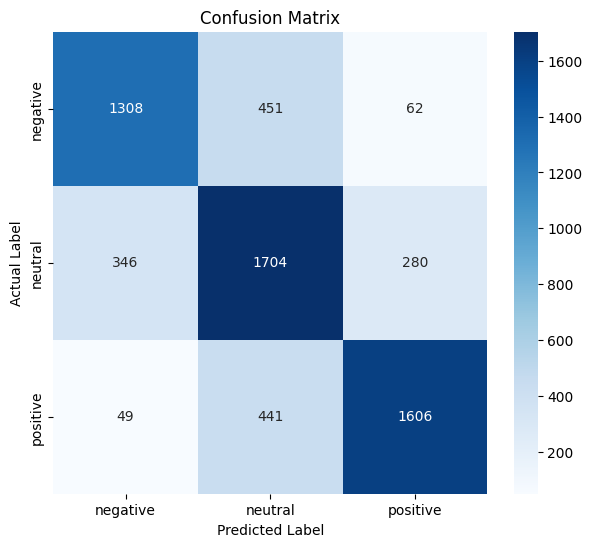


Paper Classification Report:

              precision    recall  f1-score   support

    negative       0.77      0.72      0.74      1821
     neutral       0.66      0.73      0.69      2330
    positive       0.82      0.77      0.79      2096

    accuracy                           0.74      6247
   macro avg       0.75      0.74      0.74      6247
weighted avg       0.75      0.74      0.74      6247



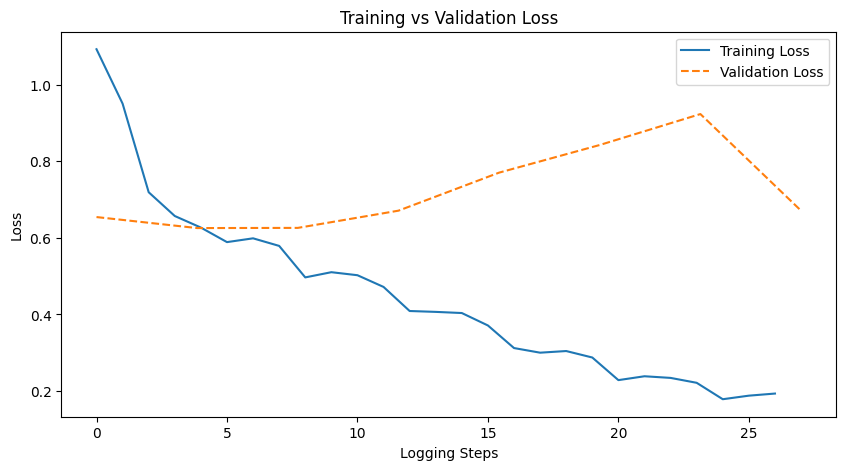

In [10]:
# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_preds)
plt.figure(figsize=(7, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2label[i] for i in range(3)], 
            yticklabels=[id2label[i] for i in range(3)])
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nPaper Classification Report:\n")
print(classification_report(y_true, y_preds, target_names=[id2label[i] for i in range(3)]))

# Visualize Training History (Loss)
history = trainer.state.log_history
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

if train_loss and eval_loss:
    plt.figure(figsize=(10, 5))
    # Interpolate to match lengths roughly for visualization if steps differ slightly
    plt.plot(train_loss, label='Training Loss')
    plt.plot(np.linspace(0, len(train_loss), len(eval_loss)), eval_loss, label='Validation Loss', linestyle='--')
    plt.xlabel('Logging Steps')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    plt.show()

## 8. Save Model 💾
We save the final trained model to the `./saved_model` directory. This is critical for `app.py` to work correctly.

In [11]:
# Save the final model
save_path = "./saved_model"
print(f"💾 Saving model to {save_path}...")
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print("✅ Model saved successfully!")

💾 Saving model to ./saved_model...
✅ Model saved successfully!


In [13]:
import os
import zipfile

model_dir = "./saved_model"
zip_path = "./saved_model.zip"

print("📦 Zipping the model...")

with zipfile.ZipFile(zip_path, "w", zipfile.ZIP_DEFLATED) as zipf:
    for root, _, files in os.walk(model_dir):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, model_dir)
            zipf.write(file_path, arcname)

print(f"✅ Model zipped successfully: {zip_path}")

📦 Zipping the model...
✅ Model zipped successfully: ./saved_model.zip
